In [1]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Directory structure
TRAIN_DIR = "PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA"
VALID_DIR = "PROCESSED_DATA/VALIDATION_DATA/"
TEST_DIR = "PROCESSED_DATA/TEST_DATA/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Data
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 6642 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.


In [3]:
# Build a CNN model
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    return model

# Build a Transfer Learning Model
def build_transfer_learning(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Invalid model name. Choose from 'ResNet50', 'EfficientNet', or 'VGG16'")
    
    base_model.trainable = False  # Freeze the base model layers
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model


#### Standard CNN without transfer learning

In [4]:
# Select the model to train
use_transfer_learning = False  # Change to False for a standard CNN
transfer_model_name = 'ResNet50'  # Options: 'ResNet50', 'EfficientNet', 'VGG16'

if use_transfer_learning:
    model = build_transfer_learning(transfer_model_name)
else:
    model = build_cnn()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Sound that plays after training model is finished
repeat_times = 3  
if os.name == 'posix':  # For macOS and Linux
    for _ in range(repeat_times):
        os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
        # Linux users: os.system('aplay /path/to/sound.wav')
        


Epoch 1/10


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 319ms/step - accuracy: 0.1257 - loss: 2.3860 - val_accuracy: 0.2455 - val_loss: 2.2163
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 321ms/step - accuracy: 0.2736 - loss: 2.1125 - val_accuracy: 0.3477 - val_loss: 2.0151
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.3651 - loss: 1.8904 - val_accuracy: 0.3886 - val_loss: 1.9546
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 69s 329ms/step - accuracy: 0.4308 - loss: 1.7132 - val_accuracy: 0.4205 - val_loss: 1.8845
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 329ms/step - accuracy: 0.5087 - loss: 1.5128 - val_accuracy: 0.4341 - val_loss: 1.8710
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 69s 329ms/step - accuracy: 0.5364 - loss: 1.3908 - val_accuracy: 0.4386 - val_loss: 1.8663
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 328ms/step - accuracy: 0.6025 - loss: 1.2232 - val_accuracy: 0.4614 - val_loss: 1.8803
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.6459 - loss: 1.0952 - val

In [5]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("pest_classifier_cnn.h5")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3842 - loss: 2.4086


Test Accuracy: 0.4000


#### Use transfer leaning: EfficientNet

In [ ]:
# Select the model to train
use_transfer_learning = True  # Change to False for a standard CNN
transfer_model_name = 'EfficientNet'  # Options: 'ResNet50', 'EfficientNet', 'VGG16'

if use_transfer_learning:
    model = build_transfer_learning(transfer_model_name)
else:
    model = build_cnn()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Sound that plays after training model is finished
repeat_times = 3  
if os.name == 'posix':  # For macOS and Linux
    for _ in range(repeat_times):
        os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
        # Linux users: os.system('aplay /path/to/sound.wav')

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("pest_classifier_cnn_efficientnet.h5")


### Evaluation Metrics

In [7]:
# ------- FUNCTIONS -------

def evaluation_metrics(model, generator, training_history):
    '''
    Params: 
    -model: trained model
    -generator: data generator for evaluation
    -training_history: from model.fit() containing training and validation metrics

    Function:
    -evaluates model performance using accuracy, precision, recall, F1 score, and macro average ROC AUC score
    -prints classification report
    -plots confusion matrix
    -plots loss curves
    -calculates macro average ROC AUC score and plots curves

    Returns: 
    -dictionary containing:
        -accuracy: model accuracy on the evaluation data
        -precision: macro averaged precision score
        -recall: macro averaged recall score
        -f1_score: macro averaged F1 score
        -classification_report_df: classification report as a dataframe

    Outputs:
    -confusion matrix plot
    -loss plots
    -macro average ROC curve plot
    -macro averaged one vs one ROC AUC score
    '''

    # True labels
    y_true = generator.classes

    # Predicted probabilities
    y_pred_probs = model.predict(generator)

    # Convert probabilities to predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    display(report_df)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(generator.class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot loss curves
    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])
    epochs = range(len(accuracy))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # ROC AUC reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # ROC curve and AUC for multi-class classification
    y_true_bin = label_binarize(y_true, classes=list(range(len(generator.class_indices))))
    n_classes = y_true_bin.shape[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "purple", "green", "gold", "deeppink", "brown", "gray", "navy"])

    for i, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred_probs[:, i],
            name=f"Class {i}",
            color=color,
            ax=ax
        )
    
    # Macro-average ROC AUC score using OvO strategy
    macro_roc_auc_ovo = roc_auc_score(y_true, 
                                      y_pred_probs, 
                                      multi_class="ovo", 
                                      average="macro")

    # ROC AUC plot reference: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
    # Plot ROC AUC curve
    ax.plot([0, 1], [0, 1], "k--", label="Chance Level (Random)")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()

    # Print macro average ROC AUC score
    print(f"Macro-averaged One-vs-One ROC AUC score: {macro_roc_auc_ovo:.2f}")

    # Key metrics
    accuracy = round(report.get("accuracy", 0.0), 3)
    precision = round(report_df.loc["macro avg", "precision"], 3)
    recall = round(report_df.loc["macro avg", "recall"], 3)
    f1_score = round(report_df.loc["macro avg", "f1-score"], 3)

    # Print key metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report_df": report_df
    }

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Classification Report:


,precision,recall,f1-score,support
adult rice weevil,0.437500,0.35,0.388889,20.0
american house spider,0.583333,0.35,0.437500,20.0
bedbug,0.454545,0.25,0.322581,20.0
brown stink bug,0.428571,0.45,0.439024,20.0
carpenter ant,0.470588,0.40,0.432432,20.0
cellar spider,0.323529,0.55,0.407407,20.0
flea,0.333333,0.35,0.341463,20.0
house centipede,0.423077,0.55,0.478261,20.0
silverfish,0.360000,0.45,0.400000,20.0
subterranean termite,0.214286,0.15,0.176471,20.0


<Figure size 800x600 with 0 Axes>

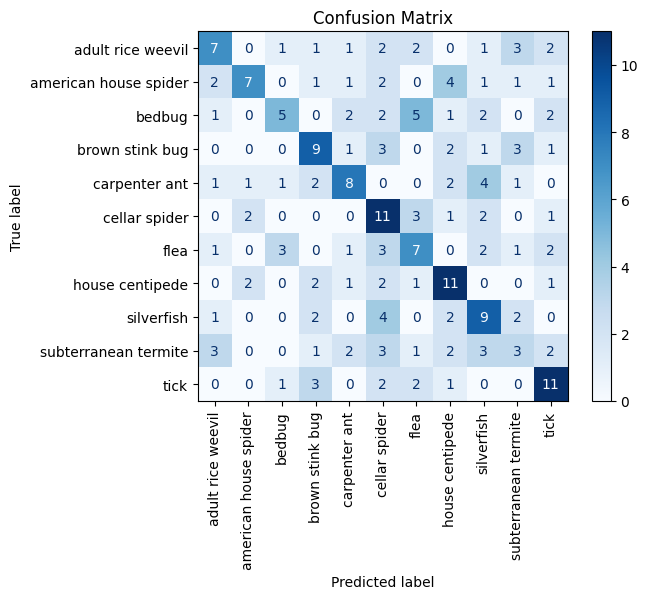

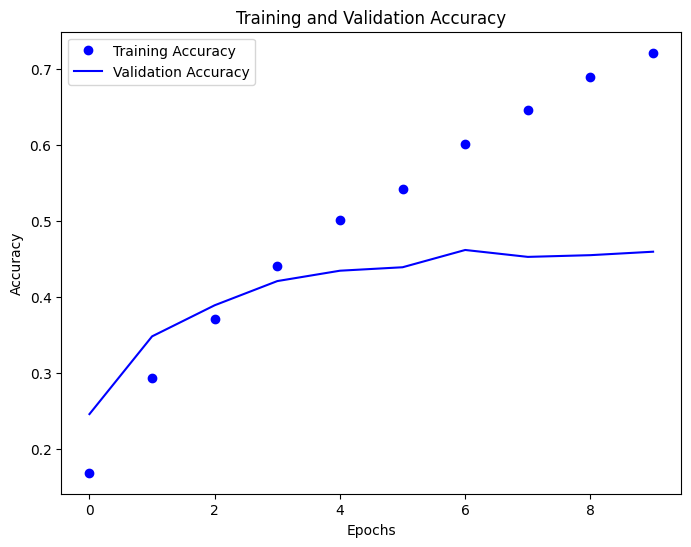

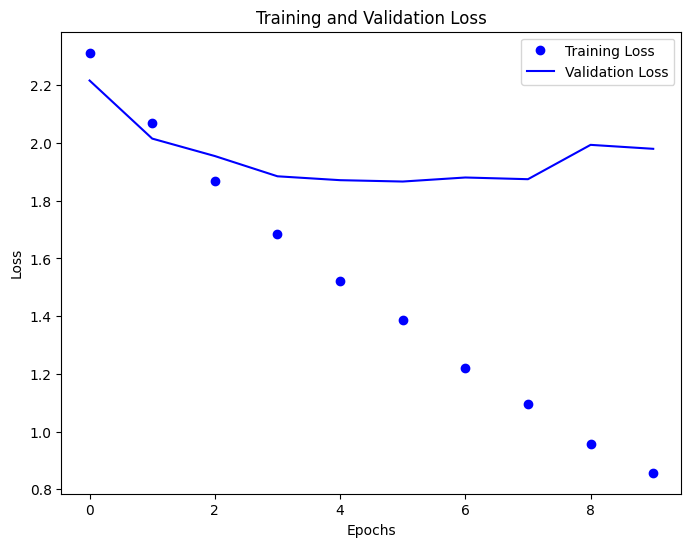

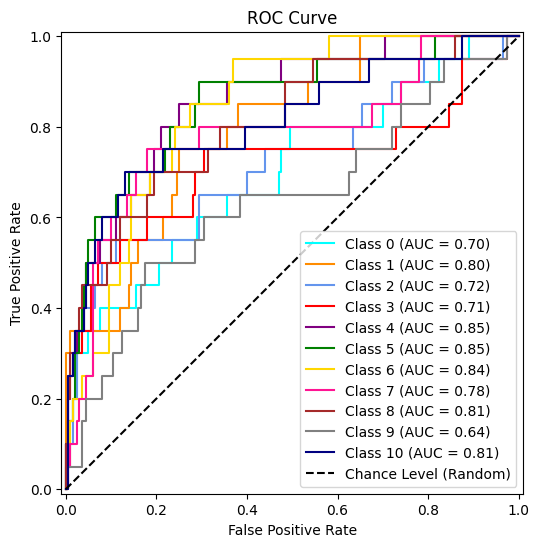

Macro-averaged One-vs-One ROC AUC score: 0.77
Accuracy: 0.4
Precision: 0.41
Recall: 0.4
F1 Score: 0.394


In [8]:
cnn_model_metrics = evaluation_metrics(model, test_generator, training_history)